In [1]:
from __future__ import division
import math
from math import sqrt, log, pi, cos, sin, tan
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
import random
plt.rc('font', serif='Myriad Pro')
plt.rc('font', size=14)
import scipy.integrate
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
def reflectance_spectrum(nu_start, nu_end, stack):
  """
  Calculate complex reflectance as a function of frequency according to the transfer matrix method
  (https://en.wikipedia.org/wiki/Transfer-matrix_method_(optics))
  Input parameters: 
  - nu_start: starting frequency in GHz
  - nu_end: end frequency in GHz
  - stack: dict whose keys are 'n' (indices of refraction of the layers) and 'L' 
  (thickness of each layer in centimeters), e.g.: 
  stack = {'n':[1, n_hdpe, 1], 'L': [np.inf, 4.1, np.inf]}
  Output: a list of complex reflectance values as a function of frequency. 
  Take np.absolute(r**2) to get the fraction of incident intensity |E^2|.
  """

  # Define physical constants
  mu_0 = 4*pi*1e-7  # henry/m, permeability of free space
  eps_0 = 8.854e-12 # farad/m, permittivity of free space
  c = 1/sqrt(eps_0*mu_0)  # speed of light for free space

  # Define frequency range of interest
  freq = np.arange(nu_start, nu_end, 0.1) * 1e9
  omega = freq*2*pi
  k = omega / c          # wavenumber, 1/m
  r = np.zeros(len(freq), dtype=complex)

  # Build up transfer matrix
  for nu in np.arange(0, len(freq)):
      M = np.identity(2) # Define a 2x2 identity matrix
      for layer in reversed(np.arange(1, len(stack['n'])-1)):   # start with second-to-last layer
          kn = k[nu]*stack['n'][layer]  # wavenumber in layer
          M_lay = np.matrix([[cos(kn*stack['L'][layer]*1e-2), 1/kn*sin(kn*stack['L'][layer]*1e-2)], 
                           [-kn*sin(kn*stack['L'][layer]*1e-2), cos(kn*stack['L'][layer]*1e-2)]])
          M = M*M_lay
      kL = k[nu]*stack['n'][0]
      kR = k[nu]*stack['n'][-1]
      r[nu] = (-1j*kR*M[0,0] + kL*kR*M[0,1] + M[1,0] + 1j*kL*M[1,1]) / (-M[1,0] + 1j*kL*M[1,1] + 1j*kR*M[0,0] + kL*kR*M[0,1])
                                                                    
  return r

In [3]:
fpath1 = '102317_data/'
fnames_cal = ['Al_sheet', 'room+holder']
fnames_thickHDPE = ['thick_hdpe_noAR', 'thick_hdpe_AR']
fnames_thinHDPE = ['thin_hdpe_noAR', 'thin_hdpe_63AR', 'thin_hdpe_81AR']
fnames_dyn = ['window_dyn', 'thicker_window_dyn', 'raw_dyn', 'CT10_dyn']

df_Al = pd.read_csv(fpath1+fnames_cal[0]+'.S1P', index_col=None, skiprows=14, delim_whitespace=True, 
                     header=None, names=['Freq', 'Power', 'Phase'])
df_room = pd.read_csv(fpath1+fnames_cal[1]+'.S1P', index_col=None, skiprows=14, delim_whitespace=True, 
                     header=None, names=['Freq', 'Power', 'Phase'])

# Specify refraction indices and bandpass
n_hdpe = 1.537; n_teadit = 1.17 # See /n/home08/mdierick/BK_pystuff/AR_coating.py for calculation of n_teadit
nu_start = 75; nu_end = 110

I. UNCOATED HDPE SLABS

1) Manual grid search

In [4]:
def minim_func_gridsearch(df, df_Al, stack):
  """
  Calculate complex reflectance as a function of frequency according to the transfer matrix method
  (https://en.wikipedia.org/wiki/Transfer-matrix_method_(optics))
  Input parameters: 
  - nu_start: starting frequency in GHz
  - nu_end: end frequency in GHz
  - stack: dict whose keys are 'n' (indices of refraction of the layers) and 'L' 
  (thickness of each layer in centimeters), e.g.: 
  stack = {'n':[1, n_hdpe, 1], 'L': [np.inf, 4.1, np.inf]}
  Output: a list of complex reflectance values as a function of frequency. 
  Take np.absolute(r**2) to get the fraction of incident intensity |E^2|.
  """

  # Define physical constants
  mu_0 = 4*pi*1e-7  # henry/m, permeability of free space
  eps_0 = 8.854e-12 # farad/m, permittivity of free space
  c = 1/sqrt(eps_0*mu_0)  # speed of light for free space

  # Initialize variables
  omega = df.Freq.values*2*pi*1e9
  k = omega / c          # wavenumber, 1/m
  r = np.zeros(len(df.Freq), dtype=complex)

  # Build up transfer matrix
  for nu in np.arange(0, len(df.Freq)):
      M = np.identity(2) # Define a 2x2 identity matrix
      for layer in reversed(np.arange(1, len(stack['n'])-1)):   # start with second-to-last layer
          kn = k[nu]*stack['n'][layer]  # wavenumber in layer
          M_lay = np.matrix([[cos(kn*stack['L'][layer]*1e-2), 1/kn*sin(kn*stack['L'][layer]*1e-2)], 
                           [-kn*sin(kn*stack['L'][layer]*1e-2), cos(kn*stack['L'][layer]*1e-2)]])
          M = M*M_lay
      kL = k[nu]*stack['n'][0]
      kR = k[nu]*stack['n'][-1]
      r[nu] = (-1j*kR*M[0,0] + kL*kR*M[0,1] + M[1,0] + 1j*kL*M[1,1]) / (-M[1,0] + 1j*kL*M[1,1] + 1j*kR*M[0,0] + kL*kR*M[0,1])
                                                                    
  # Function to minimize 

  chi_sq = np.sum( ((df.Power/df_Al.Power)**2 - np.absolute(r**2))**2)
    
  return chi_sq

In [5]:
# THICK HDPE SLAB

n_arr = np.linspace(1.48, 1.58, 50)
t_arr = np.linspace(3.8, 4.2, 50)

df_thick = pd.read_csv(fpath1+fnames_thickHDPE[0]+'.S1P', index_col=None, skiprows=14, delim_whitespace=True, 
                 header=None, names=['Freq', 'Power', 'Phase'])

chi_sq_arr = np.zeros((len(n_arr), len(t_arr)))
for n_ind in np.arange(len(n_arr)):
    for t_ind in np.arange(len(t_arr)): 
        stack = {'n':[1, n_arr[n_ind], 1], 'L': [np.inf, t_arr[t_ind], np.inf]}
        chi_sq_arr[n_ind, t_ind] = minim_func_gridsearch(df_thick, df_Al, stack)
chi_sq_arr_thick = chi_sq_arr

min_indices = np.unravel_index(chi_sq_arr_thick.argmin(), chi_sq_arr_thick.shape)
x0_thick = [n_arr[min_indices[0]], t_arr[min_indices[1]]]
print (x0_thick)

[1.5473469387755103, 4.036734693877551]


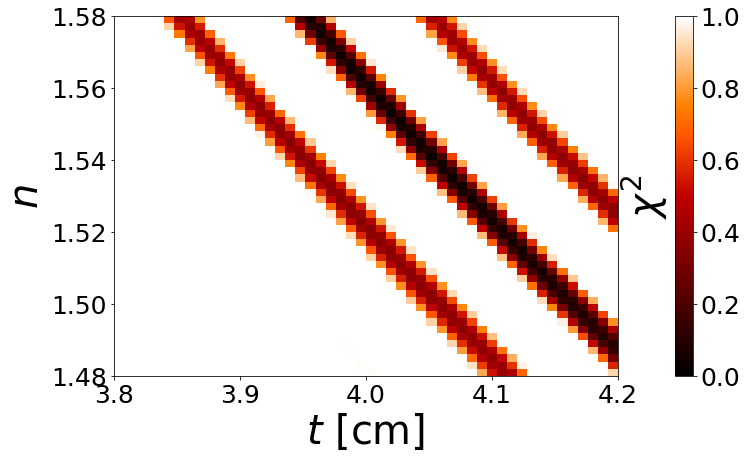

In [6]:
# Plot heat map of grid search results

low = 1

plot_name = 'Chi_map_thick.pdf'
if low == 1:
    plot_name = 'Chi_1map_thick.pdf'

H = chi_sq_arr_thick # np.log10(chi_sq_arr)
imshow_extent = [t_arr[0], t_arr[-1], n_arr[0], n_arr[-1]]
fontsize = 40; labelsize = 25
# Plot

fig = plt.figure(figsize=(7, 5))
cmap = 'gist_heat' #'gist_heat' 'YlOrRd' 'gray'
ax1 = fig.add_axes([0, 0, 1., 1.])
# x-axis
ax1.set_ylabel(r'$n$', fontsize=fontsize)
ax1.set_xlabel(r'$t$ [cm]', fontsize=fontsize)

ax1.set_ylim([imshow_extent[2], imshow_extent[3]])
im = plt.imshow(H, interpolation='nearest', aspect='auto', cmap=cmap, origin='lower', clim=(0,3),
           extent=imshow_extent)
if low == 1:
    im = plt.imshow(H, interpolation='nearest', aspect='auto', cmap=cmap, origin='lower', clim=(0, 1), 
           extent=imshow_extent)
plt.tick_params(axis='both', labelsize=labelsize)

cax = fig.add_axes([0, 0, 1.31, 1.])
frame1 = plt.gca()
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
cax.patch.set_alpha(0)
cax.set_frame_on(False)
cax.set_ylabel(r'$\chi^2$', fontsize=fontsize)
# cax.set_ylabel(r'$\log_{10}(\chi^2_r)$', fontsize=fontsize)
cax.yaxis.set_label_position("right")
cbar = plt.colorbar(im, orientation='vertical', pad = 0.09) #, ticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
cbar.ax.tick_params(labelsize=labelsize) 

# plt.savefig(plot_name, bbox_inches='tight')
plt.show()

In [7]:
# THIN HDPE SLAB

n_arr = np.linspace(1.50, 1.56, 50)
t_arr = np.linspace(0.5, 0.7, 50)

df_thin = pd.read_csv(fpath1+fnames_thinHDPE[0]+'.S1P', index_col=None, skiprows=14, delim_whitespace=True, 
                 header=None, names=['Freq', 'Power', 'Phase'])

chi_sq_arr = np.zeros((len(n_arr), len(t_arr)))
for n_ind in np.arange(len(n_arr)):
    for t_ind in np.arange(len(t_arr)): 
        stack = {'n':[1, n_arr[n_ind], 1], 'L': [np.inf, t_arr[t_ind], np.inf]}
        chi_sq_arr[n_ind, t_ind] = minim_func_gridsearch(df_thin, df_Al, stack)
chi_sq_arr_thin = chi_sq_arr

min_indices = np.unravel_index(chi_sq_arr_thin.argmin(), chi_sq_arr_thin.shape)
x0_thin = [n_arr[min_indices[0]], t_arr[min_indices[1]]]
print (x0_thin)

[1.5575510204081633, 0.61836734693877549]


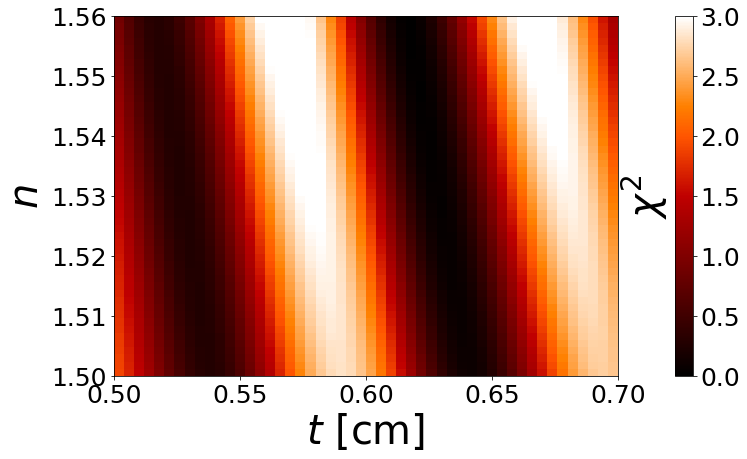

In [8]:
# Plot heat map of grid search results

low = 0

plot_name = 'Chi_map_thin.pdf'
if low == 1:
    plot_name = 'Chi_1map_thin.pdf'

H = chi_sq_arr_thin # np.log10(chi_sq_arr)
imshow_extent = [t_arr[0], t_arr[-1], n_arr[0], n_arr[-1]]
fontsize = 40; labelsize = 25
# Plot

fig = plt.figure(figsize=(7, 5))
cmap = 'gist_heat' #'gist_heat' 'YlOrRd' 'gray'
ax1 = fig.add_axes([0, 0, 1., 1.])
ax1.set_ylabel(r'$n$', fontsize=fontsize)
ax1.set_xlabel(r'$t$ [cm]', fontsize=fontsize)

# ax1.set_ylim([imshow_extent[2], imshow_extent[3]])
im = plt.imshow(H, interpolation='nearest', aspect='auto', cmap=cmap, origin='lower', clim=(0,3),
           extent=imshow_extent)
if low == 1:
    im = plt.imshow(H, interpolation='nearest', aspect='auto', cmap=cmap, origin='lower', clim=(0, 1), 
           extent=imshow_extent)
plt.tick_params(axis='both', labelsize=labelsize)

cax = fig.add_axes([0, 0, 1.31, 1.])
frame1 = plt.gca()
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
cax.patch.set_alpha(0)
cax.set_frame_on(False)
cax.set_ylabel(r'$\chi^2$', fontsize=fontsize)
# cax.set_ylabel(r'$\log_{10}(\chi^2_r)$', fontsize=fontsize)
cax.yaxis.set_label_position("right")
cbar = plt.colorbar(im, orientation='vertical', pad = 0.09) #, ticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
cbar.ax.tick_params(labelsize=labelsize) 

# plt.savefig(plot_name, bbox_inches='tight')
plt.show()

2) Minimization algorithm

In [9]:
def minim_func(x, df, df_Al):
  """
  """

  stack = {'n':[1, x[0], 1], 'L': [np.inf, x[1], np.inf]}
    
  # Define physical constants
  mu_0 = 4*pi*1e-7  # henry/m, permeability of free space
  eps_0 = 8.854e-12 # farad/m, permittivity of free space
  c = 1/sqrt(eps_0*mu_0)  # speed of light for free space

  # Initialize variables
  omega = df.Freq.values*1e9*2*pi
  k = omega / c          # wavenumber, 1/m
  r = np.zeros(len(df.Freq), dtype=complex)

  # Build up transfer matrix
  for nu in np.arange(0, len(df.Freq)):
      M = np.identity(2) # Define a 2x2 identity matrix
      for layer in reversed(np.arange(1, len(stack['n'])-1)):   # start with second-to-last layer
          kn = k[nu]*stack['n'][layer]  # wavenumber in layer
          M_lay = np.matrix([[cos(kn*stack['L'][layer]*1e-2), 1/kn*sin(kn*stack['L'][layer]*1e-2)], 
                           [-kn*sin(kn*stack['L'][layer]*1e-2), cos(kn*stack['L'][layer]*1e-2)]])
          M = M*M_lay
      kL = k[nu]*stack['n'][0]
      kR = k[nu]*stack['n'][-1]
      r[nu] = (-1j*kR*M[0,0] + kL*kR*M[0,1] + M[1,0] + 1j*kL*M[1,1]) / (-M[1,0] + 1j*kL*M[1,1] + 1j*kR*M[0,0] + kL*kR*M[0,1])
                                                                    
  # Function to minimize 

  chi_sq = np.sum( ((df.Power/df_Al.Power)**2 - np.absolute(r**2))**2)
    
  return chi_sq

In [10]:
res_thick = sp.optimize.minimize(minim_func, x0_thick, args=(df_thick,df_Al,), method='nelder-mead', 
                           options={'xtol': 1e-8, 'disp': True})
res_thin = sp.optimize.minimize(minim_func, x0_thin, args=(df_thin,df_Al,), method='nelder-mead', 
                           options={'xtol': 1e-8, 'disp': True})
print(res_thick.x)
print(res_thin.x)

Optimization terminated successfully.
         Current function value: 0.034014
         Iterations: 59
         Function evaluations: 116
Optimization terminated successfully.
         Current function value: 0.007583
         Iterations: 56
         Function evaluations: 109
[ 1.55147746  4.02685511]
[ 1.57811708  0.61030238]


[1.2306122448979593, 0.050000000000000003]


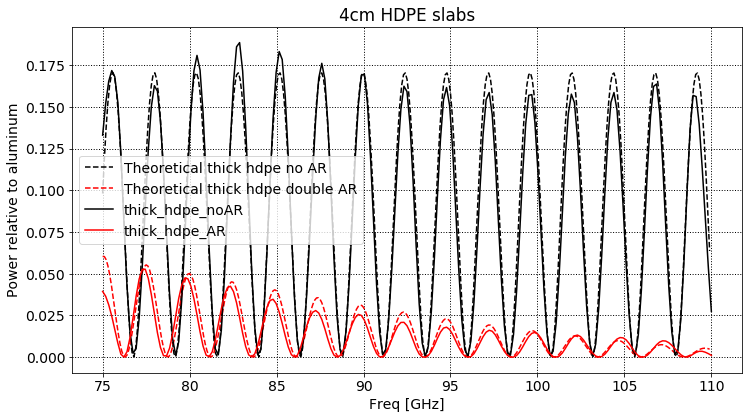

In [38]:
# THICK HDPE SLAB AR Coated Best fit

n_arr = np.linspace(1.1, 1.3, 50)
t_arr = np.linspace(.04, .05, 50)

df_thick = pd.read_csv(fpath1+'thick_HDPE_AR.S1P', index_col=None, skiprows=14, delim_whitespace=True, 
                 header=None, names=['Freq', 'Power', 'Phase'])

chi_sq_arr_AR = np.zeros((len(n_arr), len(t_arr)))
for n_ind in np.arange(len(n_arr)):
    for t_ind in np.arange(len(t_arr)): 
        stack = {'n':[1, n_arr[n_ind], 1.547, n_arr[n_ind], 1], 'L': [np.inf, t_arr[t_ind], 4.037, t_arr[n_ind], np.inf]}
        chi_sq_arr_AR[n_ind, t_ind] = minim_func_gridsearch(df_thick, df_Al, stack)
chi_sq_arr_thick_AR = chi_sq_arr_AR

min_indices = np.unravel_index(chi_sq_arr_thick_AR.argmin(), chi_sq_arr_thick_AR.shape)
x0_thick_AR = [n_arr[min_indices[0]], t_arr[min_indices[1]]]
print(x0_thick_AR)




fig = plt.figure(figsize=(12,14))
colors = ['k', 'r', 'b', 'g']

freq = np.arange(nu_start, nu_end, 0.1) * 1e9
n_hdpe = res_thick.x[0]

# Top panel: thick slabs

ax1 = fig.add_subplot(211, xlabel="Freq [GHz]", ylabel="Power relative to aluminum", title='4cm HDPE slabs')
# Theoretical predictions
stack1 = {'n':[1, res_thick.x[0], 1], 'L': [np.inf, res_thick.x[1], np.inf]} # 4.064
thick_hdpe_noAR = reflectance_spectrum(nu_start, nu_end, stack1)
ax1.plot(freq/1e9, np.absolute(thick_hdpe_noAR**2), '--', c=colors[0], label='Theoretical thick hdpe no AR')
stack2 = {'n':[1, x0_thick_AR[0], n_hdpe, x0_thick_AR[0], 1], 'L': [np.inf, x0_thick_AR[1], 3.89, x0_thick_AR[1], np.inf]}
thick_hdpe_AR = reflectance_spectrum(nu_start, nu_end, stack2)
ax1.plot(freq/1e9, np.absolute(thick_hdpe_AR**2), '--', c=colors[1], label='Theoretical thick hdpe double AR')

# Measurements
for i in np.arange(len(fnames_thickHDPE)):
    df = pd.read_csv(fpath1+fnames_thickHDPE[i]+'.S1P', index_col=None, skiprows=14, delim_whitespace=True, 
                     header=None, names=['Freq', 'Power', 'Phase'])
    ax1.plot(df.Freq, ((df.Power-df_room.Power)/df_Al.Power)**2, label=fnames_thickHDPE[i], c=colors[i])
ax1.grid(color='k', linestyle=':', linewidth=1)
plt.legend()

# Bottom panel: thin slabs

# ax2 = fig.add_subplot(212, xlabel="Freq [GHz]", ylabel="Power relative to aluminum", title='0.635cm HDPE slabs')
# # Theoretical predictions
# stack1 = {'n':[1.00029, res_thin.x[0], 1.00029], 'L': [np.inf, res_thin.x[1], np.inf]}
# thin_hdpe_noAR = reflectance_spectrum(nu_start, nu_end, stack1)
# ax2.plot(freq/1e9, np.absolute(thin_hdpe_noAR**2), '--', label='Theoretical thin hdpe no AR', c=colors[0])
# stack2 = {'n':[1.00029, n_teadit, n_hdpe, 1.00029], 'L': [np.inf, 0.063, 0.625, np.inf]}
# thin_hdpe_63AR = reflectance_spectrum(nu_start, nu_end, stack2)
# ax2.plot(freq/1e9, np.absolute(thin_hdpe_63AR**2), '--',label='Theoretical thin hdpe 0.63mm AR', c=colors[1])
# stack3 = {'n':[1.0, n_teadit, n_hdpe, 1.0], 'L': [np.inf, 0.081, 0.625, np.inf]}
# thin_hdpe_81AR = reflectance_spectrum(nu_start, nu_end, stack3)
# ax2.plot(freq/1e9, np.absolute(thin_hdpe_81AR**2), '--',label='Theoretical thin hdpe 0.81mm AR', c=colors[2])

# # Measurements
# for i in np.arange(len(fnames_thinHDPE)):
#     df = pd.read_csv(fpath1+fnames_thinHDPE[i]+'.S1P', index_col=None, skiprows=14, delim_whitespace=True, 
#                      header=None, names=['Freq', 'Power', 'Phase'])
#     ax2.plot(df.Freq, ((df.Power-df_room.Power)/df_Al.Power)**2, label=fnames_thinHDPE[i], c=colors[i])
# ax2.grid(color='k', linestyle=':', linewidth=1)
# plt.legend()

plt.savefig(fpath1+'HDPE Theoretical comparison.pdf', bboxes_inches='tight', dpi = 400)
plt.show()

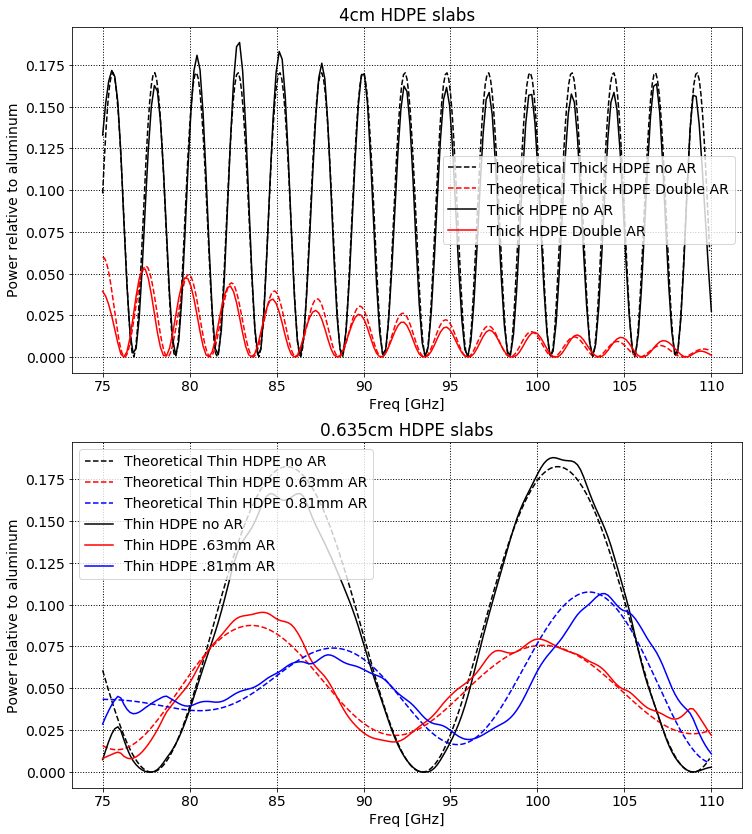

In [69]:
fig = plt.figure(figsize=(12,14))
colors = ['k', 'r', 'b', 'g']

freq = np.arange(nu_start, nu_end, 0.1) * 1e9
n_hdpe = res_thick.x[0]

legend_names_thick = ['Thick HDPE no AR','Thick HDPE Double AR']
legend_names_thin = ['Thin HDPE no AR','Thin HDPE .63mm AR', 'Thin HDPE .81mm AR']

# Top panel: thick slabs

ax1 = fig.add_subplot(211, xlabel="Freq [GHz]", ylabel="Power relative to aluminum", title='4cm HDPE slabs')
# Theoretical predictions
stack1 = {'n':[1, res_thick.x[0], 1], 'L': [np.inf, res_thick.x[1], np.inf]} # 4.064
thick_hdpe_noAR = reflectance_spectrum(nu_start, nu_end, stack1)
ax1.plot(freq/1e9, np.absolute(thick_hdpe_noAR**2), '--', c=colors[0], label='Theoretical Thick HDPE no AR')
stack2 = {'n':[1, 1.235, n_hdpe, 1.235, 1], 'L': [np.inf, .05, 3.89, .05, np.inf]}
thick_hdpe_AR = reflectance_spectrum(nu_start, nu_end, stack2)
ax1.plot(freq/1e9, np.absolute(thick_hdpe_AR**2), '--', c=colors[1], label='Theoretical Thick HDPE Double AR')

# Measurements
for i in np.arange(len(fnames_thickHDPE)):
    df = pd.read_csv(fpath1+fnames_thickHDPE[i]+'.S1P', index_col=None, skiprows=14, delim_whitespace=True, 
                     header=None, names=['Freq', 'Power', 'Phase'])
    ax1.plot(df.Freq, ((df.Power-df_room.Power)/df_Al.Power)**2, label=legend_names_thick[i], c=colors[i])
ax1.grid(color='k', linestyle=':', linewidth=1)
plt.legend()

# Bottom panel: thin slabs

ax2 = fig.add_subplot(212, xlabel="Freq [GHz]", ylabel="Power relative to aluminum", title='0.635cm HDPE slabs')
# Theoretical predictions
stack1 = {'n':[1.0, res_thin.x[0], 1.0], 'L': [np.inf, res_thin.x[1], np.inf]}
thin_hdpe_noAR = reflectance_spectrum(nu_start, nu_end, stack1)
ax2.plot(freq/1e9, np.absolute(thin_hdpe_noAR**2), '--', label='Theoretical Thin HDPE no AR', c=colors[0])
stack2 = {'n':[1.00029, 1.17, n_hdpe, 1.00029], 'L': [np.inf, 0.063, 0.625, np.inf]}
thin_hdpe_63AR = reflectance_spectrum(nu_start, nu_end, stack2)
ax2.plot(freq/1e9, np.absolute(thin_hdpe_63AR**2), '--',label='Theoretical Thin HDPE 0.63mm AR', c=colors[1])
stack3 = {'n':[1.0, 1.23, n_hdpe, 1.0], 'L': [np.inf, 0.081, 0.625, np.inf]}
thin_hdpe_81AR = reflectance_spectrum(nu_start, nu_end, stack3)
ax2.plot(freq/1e9, np.absolute(thin_hdpe_81AR**2), '--',label='Theoretical Thin HDPE 0.81mm AR', c=colors[2])

# Measurements
for i in np.arange(len(fnames_thinHDPE)):
    df = pd.read_csv(fpath1+fnames_thinHDPE[i]+'.S1P', index_col=None, skiprows=14, delim_whitespace=True, 
                     header=None, names=['Freq', 'Power', 'Phase'])
    ax2.plot(df.Freq, ((df.Power-df_room.Power)/df_Al.Power)**2, label=legend_names_thin[i], c=colors[i])
ax2.grid(color='k', linestyle=':', linewidth=1)
plt.legend()

plt.savefig(fpath1+'102317_hdpe_tests_fit.pdf', bboxes_inches='tight', dpi = 400)
plt.show()

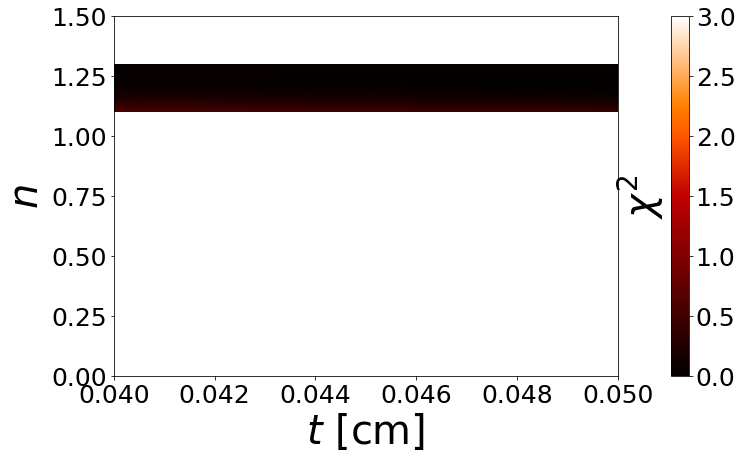

In [13]:
# Plot heat map of grid search results



plot_name = 'Chi_map_thick_AR.pdf'


H = chi_sq_arr_thick_AR # np.log10(chi_sq_arr)
imshow_extent = [t_arr[0], t_arr[-1], n_arr[0], n_arr[-1]]
fontsize = 40; labelsize = 25
# Plot

fig = plt.figure(figsize=(7, 5))
cmap = 'gist_heat' #'gist_heat' 'YlOrRd' 'gray'
ax1 = fig.add_axes([0, 0, 1., 1.])
# x-axis
ax1.set_ylabel(r'$n$', fontsize=fontsize)
ax1.set_xlabel(r'$t$ [cm]', fontsize=fontsize)

ax1.set_ylim([0, 1.5])
im = plt.imshow(H, interpolation='nearest', aspect='auto', cmap=cmap, origin='lower', clim=(0,3),
           extent=imshow_extent)
if low == 1:
    im = plt.imshow(H, interpolation='nearest', aspect='auto', cmap=cmap, origin='lower', clim=(0, 1), 
           extent=imshow_extent)
plt.tick_params(axis='both', labelsize=labelsize)

cax = fig.add_axes([0, 0, 1.3, 1.])
frame1 = plt.gca()
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
cax.patch.set_alpha(0)
cax.set_frame_on(False)
cax.set_ylabel(r'$\chi^2$', fontsize=fontsize)
# cax.set_ylabel(r'$\log_{10}(\chi^2_r)$', fontsize=fontsize)
cax.yaxis.set_label_position("right")
cbar = plt.colorbar(im, orientation='vertical', pad = 0.09) #, ticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
cbar.ax.tick_params(labelsize=labelsize) 

# plt.savefig(plot_name, bbox_inches='tight')
plt.show()

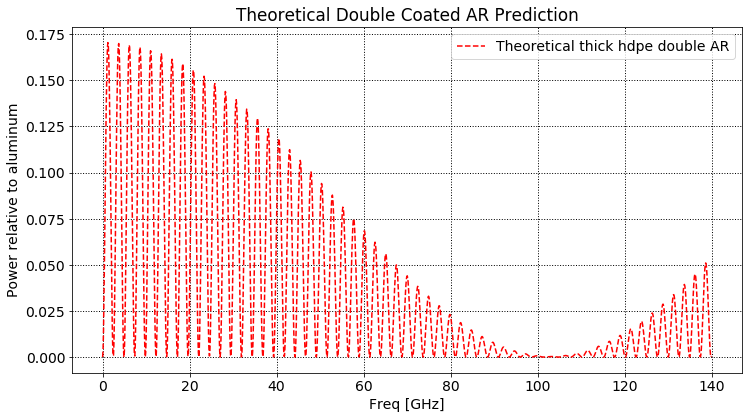

In [62]:
fig = plt.figure(figsize=(12,14))

freq = np.arange(.01, 140, 0.1) * 1e9

ax1 = fig.add_subplot(211, xlabel="Freq [GHz]", ylabel="Power relative to aluminum", title='Theoretical Double Coated AR Prediction')
stack2 = {'n':[1, 1.235, n_hdpe, 1.235, 1], 'L': [np.inf, .059, 3.89, .059, np.inf]}
thick_hdpe_AR = reflectance_spectrum(.01, 140, stack2)
ax1.plot(freq/1e9, np.absolute(thick_hdpe_AR**2), '--', c=colors[1], label='Theoretical thick hdpe double AR')

ax1.grid(color='k', linestyle=':', linewidth=1)
plt.legend()
#plt.savefig(fpath1+'doubleARprediction.png', bboxes_inches='tight', dpi = 400)
plt.show()

In [67]:
n_arr = np.linspace(1.1, 1.3, 50)
t_arr = np.linspace(.03, .1, 50)

df_thin_81 = pd.read_csv(fpath1+'thin_HDPE_81AR.S1P', index_col=None, skiprows=14, delim_whitespace=True, 
                 header=None, names=['Freq', 'Power', 'Phase'])

chi_sq_arr_AR = np.zeros((len(n_arr), len(t_arr)))
for n_ind in np.arange(len(n_arr)):
    for t_ind in np.arange(len(t_arr)): 
        stack = {'n':[1, n_arr[n_ind], 1.547, n_arr[n_ind], 1], 'L': [np.inf, t_arr[t_ind], 4.037, t_arr[n_ind], np.inf]}
        chi_sq_arr_AR[n_ind, t_ind] = minim_func_gridsearch(df_thin_81, df_Al, stack)
chi_sq_arr_thin_81AR = chi_sq_arr_AR

min_indices = np.unravel_index(chi_sq_arr_thin_81AR.argmin(), chi_sq_arr_thick_AR.shape)
x0_thin_81 = [n_arr[min_indices[0]], t_arr[min_indices[1]]]
print(x0_thin_81)

[1.3, 0.052857142857142859]
